# Working with MEG dataset
MEG dataset from THINGS initiative: https://openneuro.org/datasets/ds004212/versions/2.0.1
### Training data partition
The data is .fif file which needs to be converted into a rather easy to use .npy array.
We will use mne library for this: https://mne.tools/dev/index.html 


We collected extensively sampled object representations using magnetoencephalography (MEG). To this end, we drew on the THINGS database (Hebart et al., 2019), a richly-annotated database of 1,854 object concepts representative of the American English language which contains 26,107 manually-curated naturalistic object images.

ERP = event-related potential; signal with respect to some event
VEP = ERP for visual stimuli



27084 events, 281 time points, 271 channels

## Here we perform NMF experiements. And data matrix as concepts x channes*time

Clustering data of different participants with each other. 

In [1]:
import numpy as np # type: ignore
import mne, os # type: ignore
import matplotlib.pyplot as plt # type: ignore
import pandas as pd # type: ignore
from tqdm import tqdm # type: ignore
import matplotlib.image as mpimg # type: ignore
import nimfa # type: ignore
import scipy.stats as st # type: ignore
from sklearn.cluster import KMeans # type: ignore
from sklearn.decomposition import NMF # type: ignore
from scipy.spatial.distance import cdist # type: ignore
from scipy.optimize import nnls  # type: ignore     
from sklearn.linear_model import LinearRegression # type: ignore

### Functions

In [2]:
def compute_log_likelihood(V: np.ndarray, W: np.ndarray, H: np.ndarray):
    """Compute log-likelihood."""
    V_hat = np.dot(W, H)
    err_std_dev = np.sqrt(np.var(V - V_hat))
    log_likelihood = st.norm.logpdf(V, loc=V_hat, scale=err_std_dev).sum()
    return log_likelihood

def compute_aic(V: np.ndarray, W: np.ndarray, H: np.ndarray):
    """Compute AIC."""
    log_likelihood = compute_log_likelihood(V, W, H)
    n_free_params = np.count_nonzero(W) + np.count_nonzero(H) + 1
    aic = 2 * n_free_params - 2 * log_likelihood
    return aic, n_free_params

def compute_bic(V: np.ndarray, W: np.ndarray, H: np.ndarray):
    """Compute BIC."""
    log_likelihood = compute_log_likelihood(V, W, H)
    I, J = V.shape
    n_samples = I * J
    n_free_params = np.count_nonzero(W) + np.count_nonzero(H) + 1
    bic = np.log(n_samples) * n_free_params - 2 * log_likelihood
    return bic

def fit_bnmf(V: np.ndarray, k: int):
    bnmf = nimfa.Bd(V, seed='random_c', rank=k, max_iter=500, min_residuals=1e-4, alpha=np.zeros((V.shape[0], k)),
                        beta=np.zeros((k, V.shape[1])), theta=.0, k=.0, sigma=1., skip=100, stride=1,
                        n_w=np.zeros((k, 1)), n_h=np.zeros((k, 1)), n_run=1, n_sigma=False)
    bnmf_fit = bnmf()
    W = bnmf_fit.basis()
    H = bnmf_fit.coef()
    return np.array(W), np.array(H)

def compute_evar_all(V: np.ndarray, W: np.ndarray, H: np.ndarray):
    V_hat = np.dot(W, H)
    rss = np.sum(np.asarray(V_hat - V)**2)
    evar_all = 1. - rss / (V*V).sum()
    return evar_all

def compute_evar_indiv(V: np.ndarray, W: np.ndarray, H: np.ndarray, d: int):
    V_hat_d = np.outer(W[:, d], H[d, :])
    rss = np.sum(np.asarray(V_hat_d - V)**2)
    evar_indiv = 1. - rss / (V*V).sum()
    return evar_indiv

def compute_evar_unique(V: np.ndarray, W: np.ndarray, H: np.ndarray, d: int, evar_all: float):
    V_hat_wo_d = np.dot(W[:, np.arange(W.shape[1]) != d], H[np.arange(H.shape[0]) != d, :])
    rss = np.sum(np.asarray(V_hat_wo_d - V)**2)
    evar_rest = 1. - rss / (V*V).sum()
    evar_unique = evar_all - evar_rest
    return evar_unique

def load_epochs(preproc_dir,all_epochs = []):
    for p in range(1,n_participants+1):
        epochs = mne.read_epochs(f'{preproc_dir}/preprocessed_P{str(p)}-epo.fif', preload=False)
        all_epochs.append(epochs)
    return all_epochs

def plot_erfs(epochs,n_sessions,name):
    ctf_layout = mne.find_layout(epochs.info)
    picks_epochs = [epochs.ch_names[i] for i in np.where([s[2]==name for s in epochs.ch_names])[0]]
    picks = np.where([i[2]==name for i in ctf_layout.names])[0]

    # get evoked data
    for s in range(n_sessions):    
        evoked = epochs[(epochs.metadata['trial_type']=='test') & (epochs.metadata['session_nr']==s+1)].average()
        evoked.pick_channels(ch_names=picks_epochs)
        plt.plot(epochs.times*1000,np.mean(evoked.data.T,axis=1),lw=0.5,alpha=0.4)
    evoked = epochs[(epochs.metadata['trial_type']=='test')].average()
    evoked.pick_channels(ch_names=picks_epochs)

    # plot ERFs for selected sensor group
    plt.plot(epochs.times*1000,np.mean(evoked.data.T,axis=1),lw=1)
    plt.xlim([epochs.times[0]*1000,epochs.times[len(epochs.times)-1]*1000])
    plt.ylim([-0.6,0.6])
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude (uV)')  
    plt.title(f'ERFs for {name}')
    plt.show()  

def consensus_nmf(X, n_components=5, n_replicates=10, p=0.3, tau=0.1, random_state=0):
    """
    Perform consensus NMF on non-negative data matrix X.
    
    Parameters:
    -----------
    X : array-like of shape (N, M)
        Non-negative data. Example: N=26000 stimuli, M=271*300 (flattened sensors x time).
    n_components : int
        Number of components K in the factorization and final consensus.
    n_replicates : int
        How many times to run NMF with different random seeds.
    p : float
        Fraction that determines how many nearest neighbors to consider (L = p * R).
    tau : float
        Distance threshold for outlier filtering.
    random_state : int
        Random seed base.
    
    Returns:
    --------
    G_c : array-like, shape (K, M)
        Consensus components (space-time patterns).
    U_c : array-like, shape (N, K)
        Final usage matrix for each of the N stimuli.
    """
    
    N, M = X.shape
    K = n_components
    
    # 1) Multiple NMF replicates
    nmf_models = []
    for r in range(n_replicates):
        nmf = NMF(n_components=K, init='random', max_iter=800,
                  random_state=(random_state + r))
        U_r = nmf.fit_transform(X)
        G_r = nmf.components_  # shape (K, M)
        nmf_models.append((U_r, G_r))
    
    # 2) Normalize each component row (L2) and concatenate
    all_components = []
    for r in range(n_replicates):
        U_r, G_r = nmf_models[r]
        # L2-normalize each row in G_r
        G_r_norm = G_r / (np.linalg.norm(G_r, axis=1, keepdims=True) + 1e-12)
        all_components.append(G_r_norm)
    G_all = np.vstack(all_components)  # shape (R*K, M)
    
    # 3) Outlier Filtering
    #   L = p * R  (the user must ensure L is an integer, or round it)
    L = int(np.ceil(p * n_replicates))
    
    # For each row of G_all, find distance to its L nearest neighbors:
    distances = cdist(G_all, G_all, metric='euclidean')
    # sort distances for each row, exclude the row itself at index 0
    sorted_dists = np.sort(distances, axis=1)[:, 1:]  # skip distance to itself
    mean_L = np.mean(sorted_dists[:, :L], axis=1)     # average distance among L nearest
    # print(mean_L)
    
    # keep those with mean_L < tau
    keep_mask = mean_L < tau
    G_filt = G_all[keep_mask]
    
    # 4) KMeans cluster the filtered components
    kmeans = KMeans(n_clusters=K, random_state=random_state)
    cluster_labels = kmeans.fit_predict(G_filt)
    
    # 5) For each cluster, take the median
    G_c = np.zeros((K, M))
    for k in range(K):
        cluster_rows = G_filt[cluster_labels == k]
        if len(cluster_rows) > 0:
            G_c[k] = np.median(cluster_rows, axis=0)
        else:
            # If a cluster is empty, handle gracefully (e.g. use kmeans cluster center)
            G_c[k] = kmeans.cluster_centers_[k]
    
    # Optionally, L1-normalize each consensus row for interpretability
    G_c = G_c / (np.sum(G_c, axis=1, keepdims=True) + 1e-12)
    
    # 6) Final usage fit: fix G_c, solve for U_c >= 0
    #    We can do it by NMF with init='custom', or by non-negative least squares.
    #    For brevity, here's a quick approach reusing NMF with fix_components style:
    nmf_final = NMF(n_components=K, init='random', max_iter=200, random_state=random_state)
    # We'll set G_c as the init for nmf.components_ and disallow updates to it.
    nmf_final.components_ = G_c.copy()  # shape (K, M)
    # scikit-learn doesn't have a built-in "freeze components" option, so we do partial fit:
    # We'll just do transform with non-negative least squares on each row of X.
    
    # U_c shape: (N, K)
    from sklearn.linear_model import LinearRegression
    U_c = np.zeros((N, K))
    for i in range(N):
        # Solve  min_{u>=0} || X[i,:] - u * G_c ||^2
        # G_c is (K, M), X[i,:] is (M,)
        # This is a standard non-negative LS problem. We can do a quick non-negative solve:
        # For simplicity, we'll do a positivity hack with SciPy or a bigger approach. Let’s do a naive loop:
        
        # OPTIONAL: from scipy.optimize import nnls
        # u_i, _ = nnls(G_c.T, X[i,:])
        # U_c[i,:] = u_i
        # (But let’s just do that if SciPy is allowed. If not, we do an unconstrained solve then clip.)
        
        # Unconstrained LS:
        reg = LinearRegression(fit_intercept=False)
        reg.fit(G_c.T, X[i,:])
        u_pred = reg.coef_
        # Clip negative to 0:
        u_pred[u_pred < 0] = 0
        U_c[i,:] = u_pred
    
    # Finally, normalize each row of U_c so usage sums to 1 across components (if desired)
    row_sums = np.sum(U_c, axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1.0  # avoid division by zero
    U_c = U_c / row_sums
    
    return G_c, U_c

# ----------------------
# # Example usage:
# if __name__ == "__main__":
#     # Suppose we have MEG data loaded as a 26k x (271*300) matrix
#     # (For demonstration, we’ll just make random non-negative data.)
#     np.random.seed(42)
#     N = 26000
#     M = 271 * 300
#     X_demo = np.random.rand(N, M)  # Already non-negative

#     # Run cNMF with K=5
#     G_c, U_c = consensus_nmf(X_demo, 
#                              n_components=5,
#                              n_replicates=10,
#                              p=0.3,
#                              tau=0.1,
#                              random_state=42)

#     print("G_c shape:", G_c.shape)  # Should be (5, M)
#     print("U_c shape:", U_c.shape)  # Should be (N, 5)
    
#     # "Unwrap" a row of G_c to see sensor x time pattern:
#     # e.g., G_c[0].reshape(271, 300)



In [3]:
channel_picks = ['O','T','P'] 
preproc_dir = '../data/preprocessed'
image_dir = '../data/'

time_window = [0 , 0.8] # in seconds
n_participants = 4 # total number of participants
participant_nos = [0, 2] # participant number 0 - 3
images_to_show = 20
nmf_components = 10
random_state = 1
nos_seeds = 10

NOS_CONCEPTS = 1854
NOS_IMAGE_PER_CONCEPT = 12
NOS_TIME_POINTS = 281
OPTICAL_CHANNELS = True # False if all channels are used

### Class

In [ ]:
class IDK:
    def __init__(self, all_epochs):
        self.all_epochs = all_epochs
        self.n_participants = len(all_epochs)
        self.W_dict = {}
        self.H_dict = {}
        self.X_dict = {}
        self.nnls_results = {}
        self.NOS_CONCEPTS = 1854
        self.NOS_IMAGE_PER_CONCEPT = 12
        self.NOS_TOTAL_TIME_POINTS = 281
        
    def make_W_H(self, participant_no):
        epochs = self.all_epochs[participant_no]
        time_points = epochs.times
        self.time_points = time_points
        name = channel_picks[0]
        print(name, channel_picks)
        # ctf_layout = mne.find_layout(epochs.info)
        picks_epochs = [epochs.ch_names[i] for i in np.where([s[2]==name for s in epochs.ch_names])[0]]
        ep1 = epochs[epochs.metadata['trial_type']=='exp']  
        ep1.load_data()
        self.NOS_TOTAL_TIME_POINTS = 281
        if OPTICAL_CHANNELS:
            self.NOS_CHANNELS_OPT = 39
            ep1.pick_channels(ch_names=picks_epochs); # supress output
        else:
            self.NOS_CHANNELS_OPT = 271

        # Initialize the concept_epochs array with zeros
        concept_epochs = np.zeros((self.NOS_IMAGE_PER_CONCEPT, self.NOS_CONCEPTS, self.NOS_TOTAL_TIME_POINTS, self.NOS_CHANNELS_OPT))
        category_nrs = ep1.metadata['category_nr'].to_numpy()
        session_nrs = ep1.metadata['session_nr'].to_numpy()

        # Precompute masks for categories and sessions
        category_masks = [(category_nrs == (cat_nr + 1)) for cat_nr in range(self.NOS_CONCEPTS)]
        session_masks = [(session_nrs == (img_nr + 1)) for img_nr in range(self.NOS_IMAGE_PER_CONCEPT)]

        # Fill concept_epochs efficiently
        for category_nr, category_mask in enumerate(category_masks):
            for img_nr, session_mask in enumerate(session_masks):
                mask = category_mask & session_mask
                concept_epochs[img_nr, category_nr, :, :] = ep1._data[mask].transpose(0, 2, 1)
        concept_epochs = concept_epochs[:, :, (time_points >= time_window[0]) & (time_points <= time_window[1]), :]
        time_points = time_points[(time_points >= time_window[0]) & (time_points <= time_window[1])]
        self.time_points_new = time_points
        self.NOS_TIME_POINTS = concept_epochs.shape[2]
        average_concept_epochs = concept_epochs.mean(axis = 0)
        temp = average_concept_epochs[:,:,:] - average_concept_epochs.mean(axis = (0,1)) # making sure each channel is centered
        # set outlier points to max value 
        dev = 5*np.std(temp)
        temp[temp > dev] = dev
        temp[temp < - dev] = - dev
        temp = temp - np.min(temp)
        # plt.hist(temp.flatten(), bins = 100)
        # plt.title("Histogram of reshaped data")
        # plt.show()
        X = temp.transpose(0,2,1).reshape(self.NOS_CONCEPTS, self.NOS_TIME_POINTS * self.NOS_CHANNELS_OPT) 
        X = X - X.min()
        H, W = consensus_nmf(X, n_components=nmf_components, n_replicates=nos_seeds, p=0.3, tau=1, random_state=random_state)
        # make a dictionary of results
        self.W_dict[participant_no] = W
        self.H_dict[participant_no] = H     
        self.X_dict[participant_no] = X
        return H, W, X

    def plot_results(self, participant_no):
        W = self.W_dict[participant_no]
        epochs = self.all_epochs[participant_no]    
        nmf_components_vs_category = np.zeros((nmf_components, images_to_show))
        for i in range(nmf_components):
            sorted_indices = np.argsort(W[:,i])
            # print(f'Categories which are best on component {i} are: {sorted_indices[-images_to_show:]}')
            nmf_components_vs_category[i,:] = sorted_indices[-images_to_show:]
        # plot images for the top 5 categories for each component  
        category_array_name = []
        for component in range(nmf_components):
            if component > 20:
                break
            print(f"Component {component} is best loaded by the following image categories:")
            category_array = []
            fig, axs = plt.subplots(1, images_to_show, figsize=(40, 40))
            for i in range(images_to_show):
                category_nr = nmf_components_vs_category[component, i] 
                # Get the image paths for the given category_nr
                image_paths = epochs.metadata[(epochs.metadata['category_nr'] == category_nr+1) & (epochs.metadata['trial_type'] == 'exp')]['image_path']
                image_path = image_paths.iloc[0]
                image_path = f'{image_dir}{image_path}'
                img = mpimg.imread(image_path)
                category_array.append(image_path.split('/')[-2])
                axs[i].imshow(img)
                axs[i].set_title(f"Category {category_nr}")
                axs[i].axis('off')
            plt.show()
            category_array_name.append(category_array)

    def perform_plot_nnls(self, participant_no, baseline_regressor = False):
        W = self.W_dict[participant_no]
        X = self.X_dict[participant_no]
        X_scaled = X.reshape(self.NOS_CONCEPTS, self.NOS_CHANNELS_OPT, self.NOS_TIME_POINTS)
        # X_scaled = X_scaled / X_scaled.max(axis=0)
        # adding baseline regressor to W
        if baseline_regressor:
            W = W.T  # Now W is (10, 1854)
            W = np.vstack([W, np.ones((1, W.shape[1]))]).T  # Now W is (11, 1854)
            W = W / (np.linalg.norm(W, axis=1, keepdims=True)) # to make sure nnls converges
            nnls_results = np.zeros((nmf_components + 1, self.NOS_CHANNELS_OPT, self.NOS_TIME_POINTS))
        else:
            nnls_results = np.zeros((nmf_components, self.NOS_CHANNELS_OPT, self.NOS_TIME_POINTS))
        for channel in range(self.NOS_CHANNELS_OPT):
            for t in range(self.NOS_TIME_POINTS):
                nnls_results[:, channel, t] = nnls(W, X_scaled[:,channel,t])[0]
        # --- Example Plot ---
        # Plot the NNLS coefficient time series for channel 0 for all components.
        time_points = np.arange(self.NOS_TIME_POINTS)
        plt.figure(figsize=(20, 5))
        for comp in range(nmf_components):
            plt.plot(time_points, nnls_results[comp, 0, :], alpha=0.7, label=f"Component {comp}")
        plt.title("NNLS Coefficients Over Time for Channel 0 (Locally Scaled)")
        plt.xlabel("Time (ms)")
        plt.ylabel("Coefficient (scaled)")
        plt.legend()
        plt.show()
        self.nnls_results[participant_no] = nnls_results
        return nnls_results

In [5]:
idk = IDK(load_epochs(preproc_dir))
_, _ , _ = idk.make_W_H(2)

Reading /home/atharvsagar/Documents/Neural-Representations-using-Things-Database/notebooks/../data/preprocessed/preprocessed_P1-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/atharvsagar/Documents/Neural-Representations-using-Things-Database/notebooks/../data/preprocessed/preprocessed_P1-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/atharvsagar/Documents/Neural-Representations-using-Things-Database/notebooks/../data/preprocessed/preprocessed_P1-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/atharvsagar/Documents/Neural-Representations-using-Things-Database/notebooks/../data/preprocessed/preprocessed_P1-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 

/home/atharvsagar/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 800 reached. Increase it to improve convergence.
  warnings.warn(
/home/atharvsagar/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 800 reached. Increase it to improve convergence.
  warnings.warn(
/home/atharvsagar/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 800 reached. Increase it to improve convergence.
  warnings.warn(
/home/atharvsagar/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 800 reached. Increase it to improve convergence.
  warnings.warn(
/home/atharvsagar/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 800 reached. Increase it t

In [6]:
_, _, _ = idk.make_W_H(1)

O ['O', 'T', 'P']
Loading data for 22248 events and 281 original time points ...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/home/atharvsagar/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 800 reached. Increase it to improve convergence.
  warnings.warn(
/home/atharvsagar/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 800 reached. Increase it to improve convergence.
  warnings.warn(
/home/atharvsagar/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 800 reached. Increase it to improve convergence.
  warnings.warn(
/home/atharvsagar/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 800 reached. Increase it to improve convergence.
  warnings.warn(
/home/atharvsagar/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 800 reached. Increase it t

### Finding common components across participants

In [7]:
H_part1 = idk.H_dict[1].reshape(nmf_components, idk.NOS_CHANNELS_OPT, idk.NOS_TIME_POINTS).mean(axis = 1)
H_part2 = idk.H_dict[2].reshape(nmf_components, idk.NOS_CHANNELS_OPT, idk.NOS_TIME_POINTS).mean(axis = 1)
print(H_part1.shape)



(10, 161)


In [ ]:
def make_corr_mat(a, b, n):
    '''
    a: np.array of shape (n, m)
    b: np.array of shape (n, m)
    n: number of components

    returns: np.array of shape (n, n) with correlation coefficients between components of a and b
    '''                 
    corr_mat = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            corr_mat[i,j] = np.corrcoef(a[i,:], b[j,:])[0,1]
    return corr_mat

[[(4, 9), 0.9739516801578989], [(6, 6), 0.9462622067291712], [(7, 8), 0.9315361824775356], [(0, 4), 0.9277022963201983], [(9, 3), 0.9099662127521925], [(2, 2), 0.8223785683237322], [(3, 0), 0.7665889353551356], [(8, 7), 0.4362775788224853], [(1, 1), 0.23052739431996844], [(5, 5), 0.21442234234810098]]


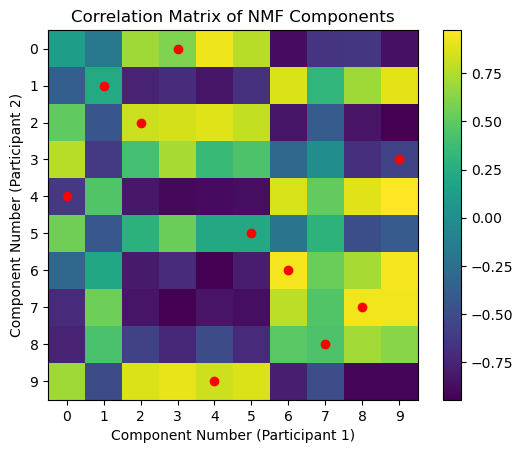

In [34]:

# Compute correlation matrix
corr_matrix = make_corr_mat(H_part1, H_part2, nmf_components)
plt.imshow(corr_matrix, cmap='viridis')  
plt.colorbar()  
plt.title("Correlation Matrix of NMF Components")
# Exclude diagonal (self-correlation) by setting it to NaN
# np.fill_diagonal(corr_matrix, np.nan)

# Get sorted indices of correlation values (flattened array)
sorted_indices = np.argsort(-np.nan_to_num(corr_matrix).ravel())  # Negative for descending order

# Convert back to 2D indices
sorted_2d_indices = np.unravel_index(sorted_indices, corr_matrix.shape)

# Stack row & col indices into tuples
sorted_pairs = list(zip(sorted_2d_indices[0], sorted_2d_indices[1]))

# Get top 10 correlated pairs
max_corr_pairs = sorted_pairs[:60]

# Ensure unique indices
unique_pairs = []
used_indices_p1 = set()  # Track already used indices participant 1
used_indices_p2 = set()  # Track already used indices participant 2

for pair in max_corr_pairs:
    if pair[0] not in used_indices_p1 and pair[1] not in used_indices_p2:
        unique_pairs.append(pair)
        used_indices_p1.add(pair[0])  # Use add() for single values
        used_indices_p2.add(pair[1])


print([[unique_pair, corr_matrix[unique_pair[0], unique_pair[1]]] for unique_pair in unique_pairs])# Mark unique pairs in the correlation matrix   
plt.plot([pair[0] for pair in unique_pairs], [pair[1] for pair in unique_pairs], 'ro')  
# plt.plot([pair[1] for pair in unique_pairs], [pair[0] for pair in unique_pairs], 'ro')  
plt.xlabel("Component Number (Participant 1)")
plt.ylabel("Component Number (Participant 2)")
plt.xticks(range(nmf_components))
plt.yticks(range(nmf_components))
plt.show()


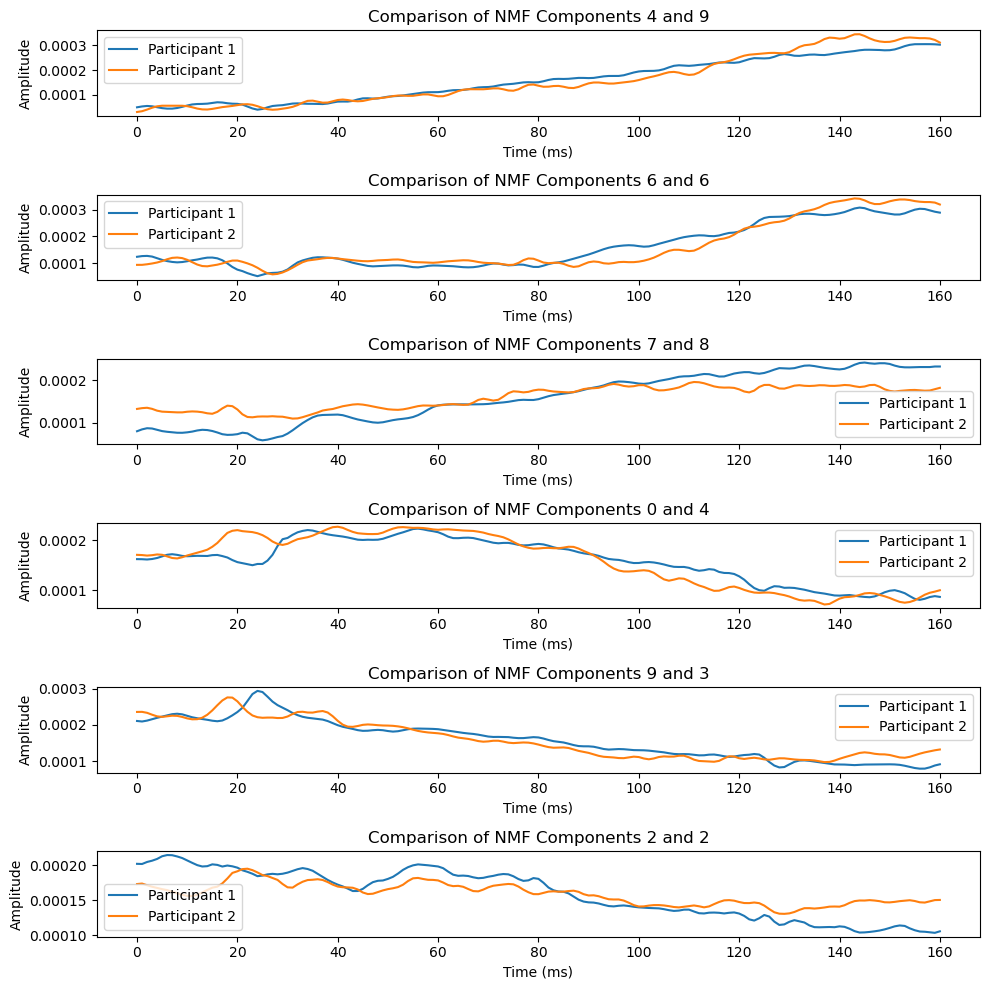

In [35]:
# plt.plot(H_part1[4,:], label='Participant 1')
# plt.plot(H_part2[7,:], label='Participant 2')   
# plt.xlabel("Time (ms)")
# plt.ylabel("Amplitude")
# plt.title("Comparison of NMF Components for Participant 1 and Participant 2")
# plt.legend()
# plt.show()

# subplot for first 4 pair of component with highest correlation
fig, axs = plt.subplots(6, 1, figsize=(10, 10)) 
for i, pair in enumerate(unique_pairs[:6]):
    axs[i].plot(H_part1[pair[0],:161], label='Participant 1')
    axs[i].plot(H_part2[pair[1],:161], label='Participant 2')
    axs[i].set_title(f"Comparison of NMF Components {pair[0]} and {pair[1]}")
    axs[i].set_xlabel("Time (ms)")
    axs[i].set_ylabel("Amplitude")
    axs[i].legend()
plt.tight_layout()
plt.show()


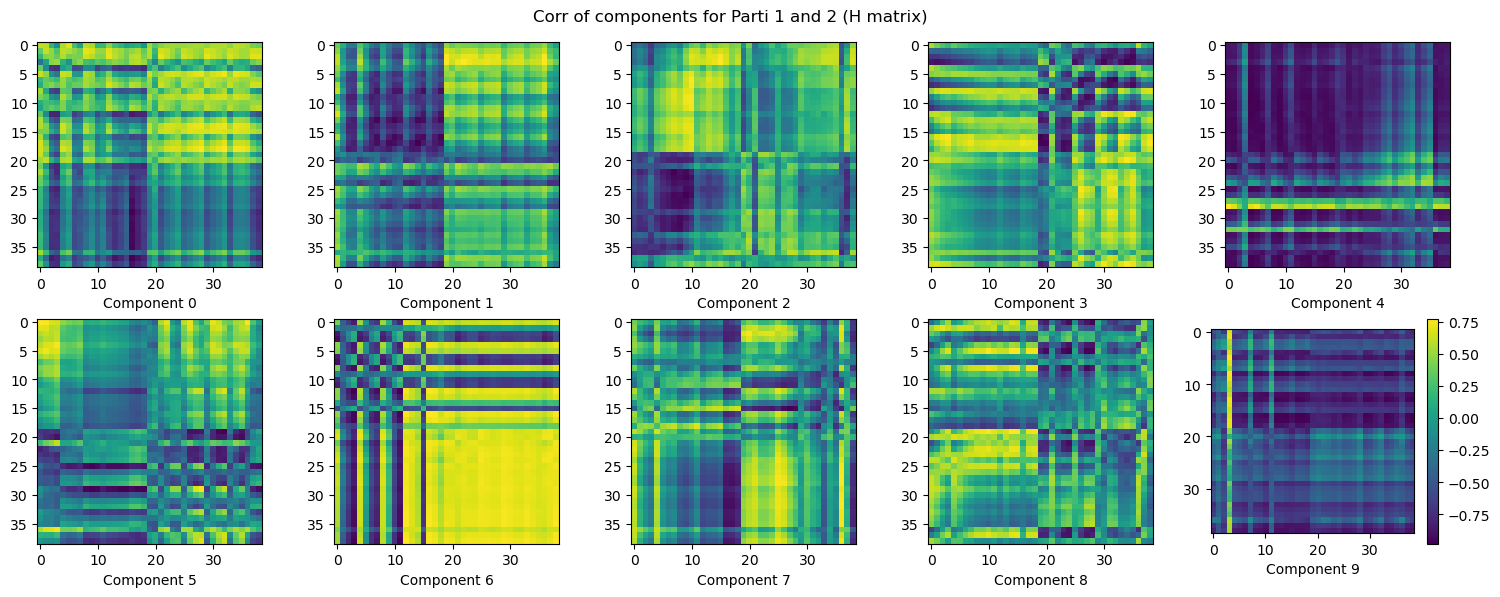

In [36]:
temp1 = idk.H_dict[1].reshape(nmf_components, idk.NOS_CHANNELS_OPT, idk.NOS_TIME_POINTS)
temp2 = idk.H_dict[2].reshape(nmf_components, idk.NOS_CHANNELS_OPT, idk.NOS_TIME_POINTS)
# Compute the correlation matrix across all channels for each component to give 10 subplots of imshow
plt.subplots(2, 5, figsize=(15, 6))
plt.suptitle("Corr of components for Parti 1 and 2 (H matrix)")   
for i in range(nmf_components):
    corr_mat = make_corr_mat(temp1[i,:,:], temp2[i,:,:], idk.NOS_CHANNELS_OPT)
    plt.subplot(2, 5, i+1)
    plt.imshow(corr_mat, cmap='viridis')    
    plt.xlabel(f"Component {i}")
plt.tight_layout()       
plt.colorbar()  
plt.show()  

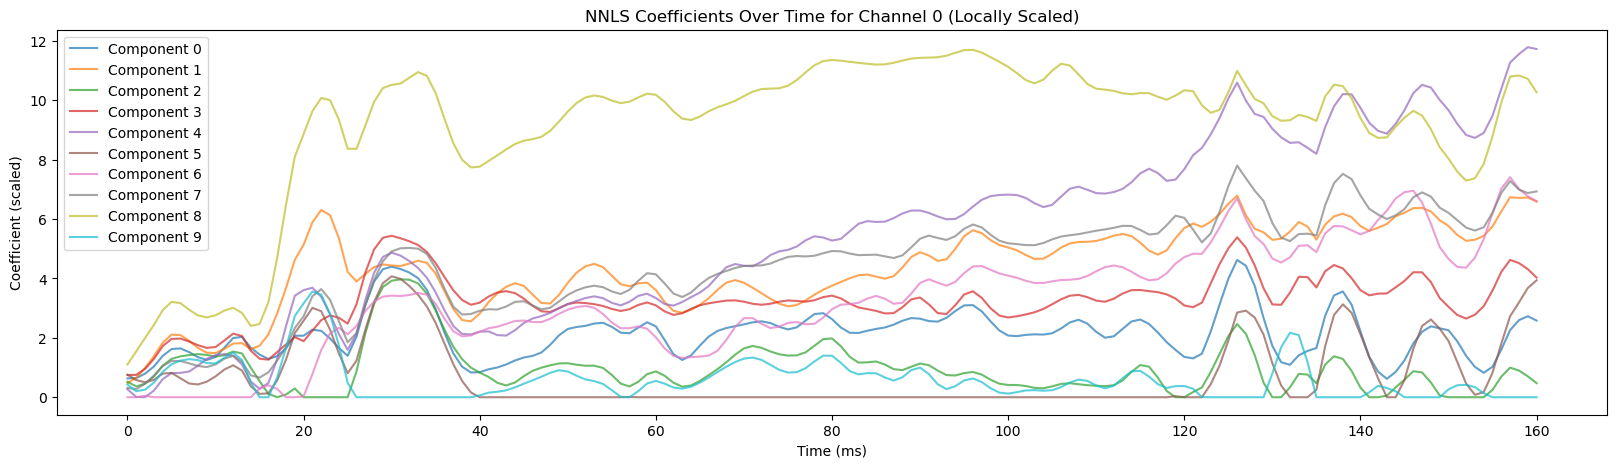

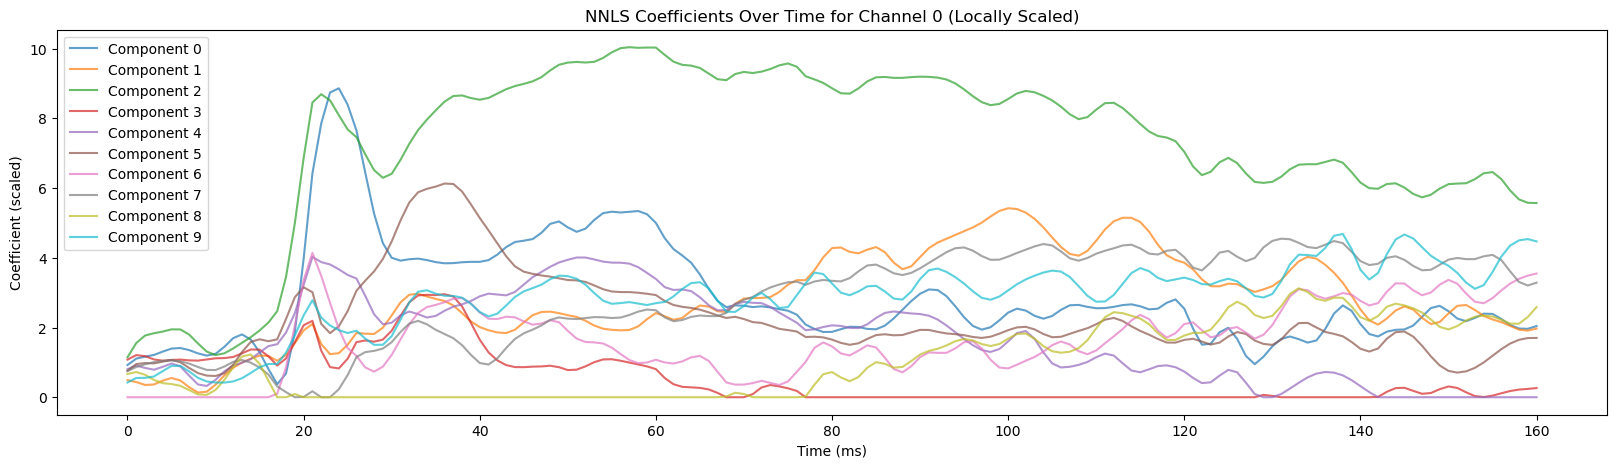

In [44]:
nnls_1 = idk.perform_plot_nnls(participant_no=1, baseline_regressor=True)
nnls_2 = idk.perform_plot_nnls(participant_no=2, baseline_regressor=True)  

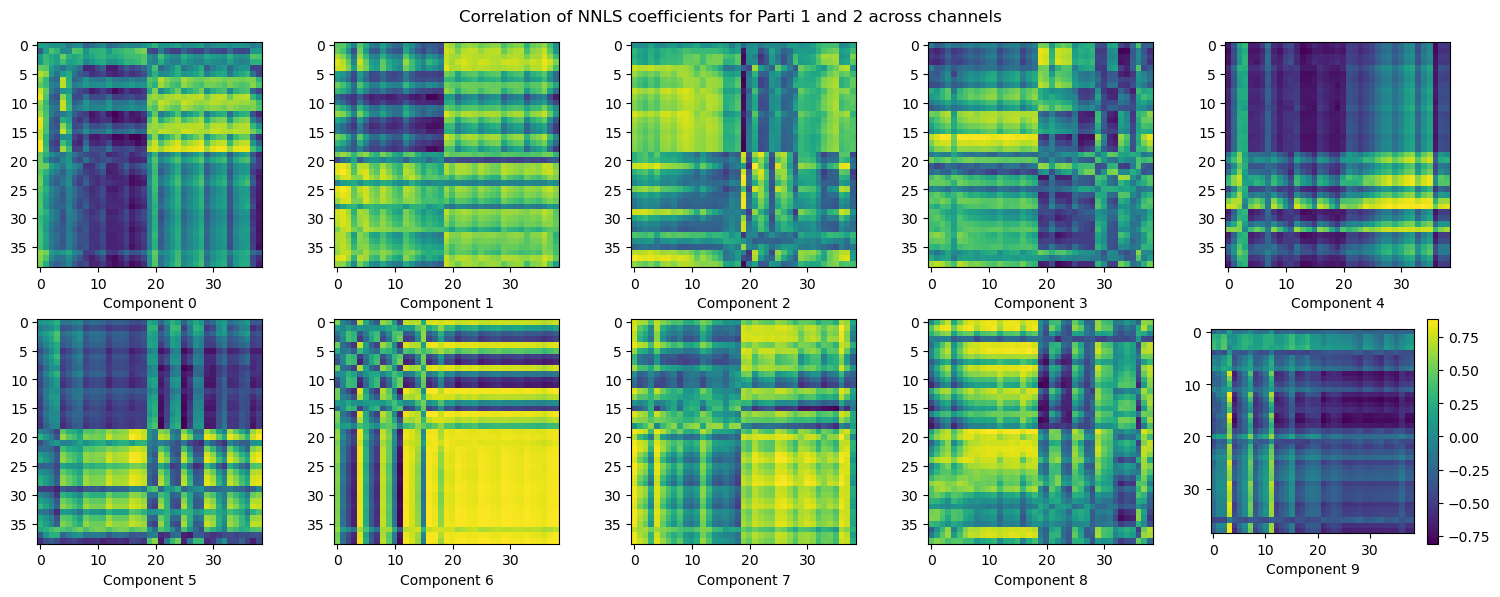

In [48]:
# compute the correlation matrices for each component across channels 
# and subplot then (make 11 subplots)
axs, fig = plt.subplots(2, 5, figsize=(15, 6))
plt.suptitle("Correlation of NNLS coefficients for Parti 1 and 2 across channels")
for i in range(nmf_components):
    corr_mat = make_corr_mat(nnls_1[i,:,:], nnls_2[i,:,:], idk.NOS_CHANNELS_OPT)
    plt.subplot(2, 5, i+1)
    plt.imshow(corr_mat, cmap='viridis')    
    plt.xlabel(f"Component {i}")
plt.tight_layout()      
plt.colorbar()  
plt.show()

We see a lot of variation across channels, so we try to do PCA/NMF and see if one component can 

Participant 1 explained variance ratio
Component 0 explained variance ratio: 0.7786273025631489
Component 1 explained variance ratio: 0.7279170228566689
Component 2 explained variance ratio: 0.8722204157739163
Component 3 explained variance ratio: 0.6956230274636201
Component 4 explained variance ratio: 0.9492631244779874
Component 5 explained variance ratio: 0.80811930007329
Component 6 explained variance ratio: 0.8774351655480441
Component 7 explained variance ratio: 0.898819231003307
Component 8 explained variance ratio: 0.7242953647171507
Component 9 explained variance ratio: 0.7997282243525208


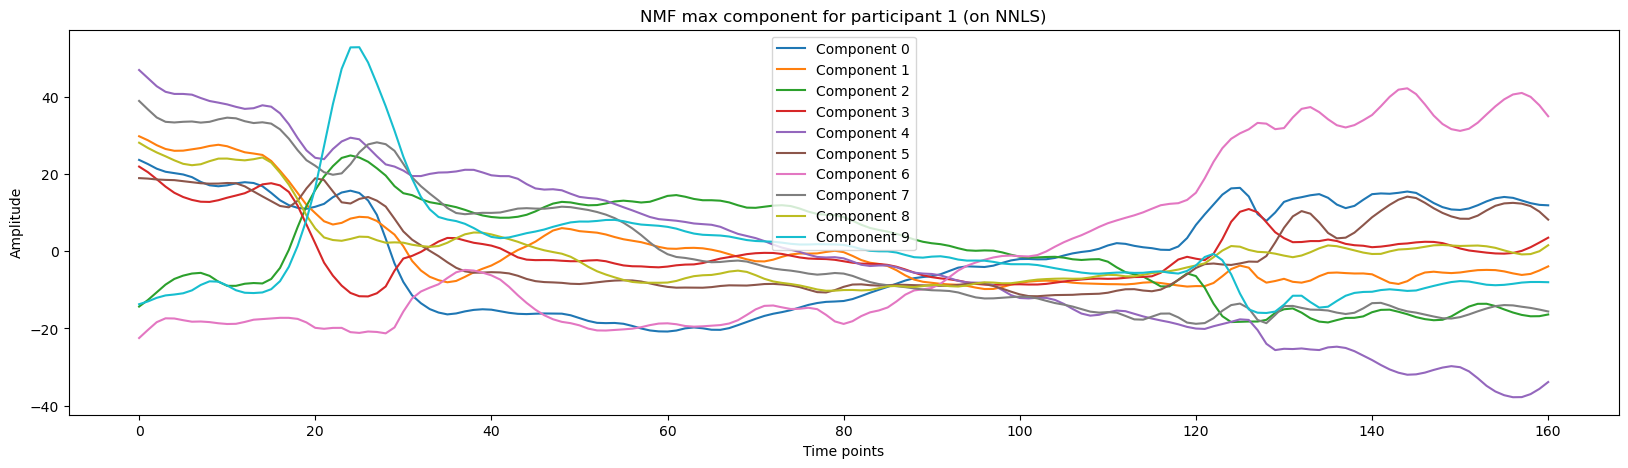

Participant 2
Component 0 explained variance ratio: 0.8144231612339551
Component 1 explained variance ratio: 0.7275427120027571
Component 2 explained variance ratio: 0.789329524163943
Component 3 explained variance ratio: 0.78752356211918
Component 4 explained variance ratio: 0.8166740711055799
Component 5 explained variance ratio: 0.7908914576908925
Component 6 explained variance ratio: 0.9376930045785734
Component 7 explained variance ratio: 0.6986707878276853
Component 8 explained variance ratio: 0.8484417859747092
Component 9 explained variance ratio: 0.9455701027894409


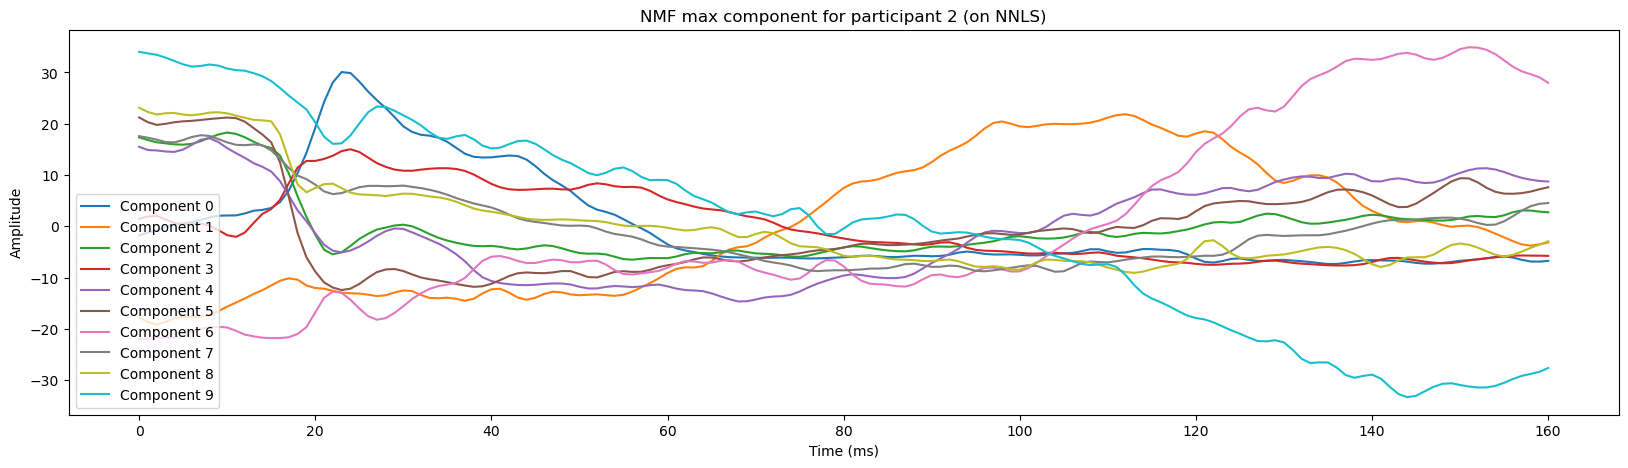

In [94]:
plt.figure(figsize=(20, 5))
plt.title("NMF max component for participant 1 (on NNLS)")
print("Participant 1 explained variance ratio")
for i in range(nmf_components):
    pca = PCA(n_components=1)
    a = pca.fit_transform(nnls_1[i,:,:].T) 
    print(f"Component {i} explained variance ratio: {pca.explained_variance_ratio_[0]}")   
    plt.plot(a, label = f'Component {i}')
plt.ylabel("Amplitude")
plt.xlabel("Time points")   
plt.legend()
plt.show()

plt.figure(figsize=(20, 5))
plt.title("NMF max component for participant 2 (on NNLS)")
print("Participant 2")
for i in range(nmf_components):
    pca = PCA(n_components=1)
    a = pca.fit_transform(nnls_2[i,:,:].T) 
    print(f"Component {i} explained variance ratio: {pca.explained_variance_ratio_[0]}")   
    plt.plot(a, label = f'Component {i}')
plt.legend()
plt.ylabel("Amplitude")
plt.xlabel("Time (ms)") 
plt.show()

# pca = PCA(n_components=1)
# a = pca.fit_transform(nnls_1[1,:,:].T)
# a.shape
# plt.plot(a)

[0.81153288]


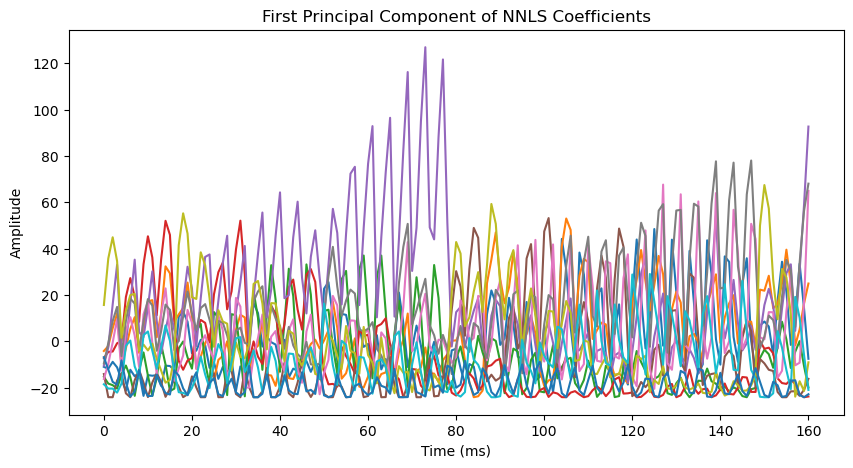

In [65]:
# Reshape to (samples, features) = (11 * 161, 39)
X_pca = nnls_1.reshape(11 * 161, 39)
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=1)  # Extract the first principal component
principal_component = pca.fit_transform(X_pca)  # Shape: (11 * 161, 1)

# Reshape back to (11, 161) so we retain component-time structure
principal_component = principal_component.reshape(11, 161)
print(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 5)) 
plt.plot(principal_component.T)
plt.title("First Principal Component of NNLS Coefficients")
plt.xlabel("Time (ms)") 
plt.ylabel("Amplitude") 
plt.show()

For participant 1 PCA on NNLS
Explained variance ratio for component 0 is [0.82249887]
Explained variance ratio for component 1 is [0.88945636]
Explained variance ratio for component 2 is [0.87668194]
Explained variance ratio for component 3 is [0.9490914]
Explained variance ratio for component 4 is [0.96431954]
Explained variance ratio for component 5 is [0.92512582]
Explained variance ratio for component 6 is [0.90088351]
Explained variance ratio for component 7 is [0.91178069]
Explained variance ratio for component 8 is [0.92835475]
Explained variance ratio for component 9 is [0.74584312]
For participant 2 PCA on NNLS
Explained variance ratio for component 0 is [0.71998387]
Explained variance ratio for component 1 is [0.80794737]
Explained variance ratio for component 2 is [0.95931508]
Explained variance ratio for component 3 is [0.62071697]
Explained variance ratio for component 4 is [0.92914722]
Explained variance ratio for component 5 is [0.91407511]
Explained variance ratio for 

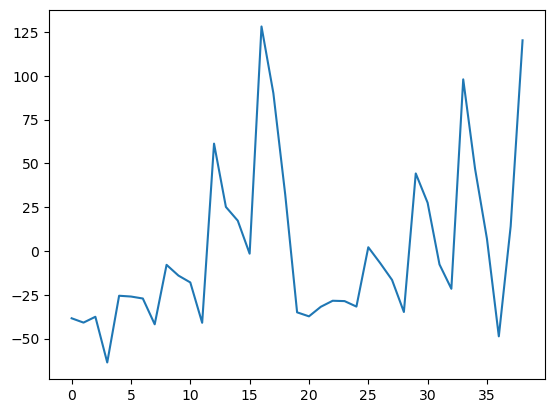

In [58]:
# doing PCA on NNLS results 
from sklearn.decomposition import PCA
print("For participant 1 PCA on NNLS")
pca = PCA(n_components=1)
for i in range(nmf_components):
    principalComponents = pca.fit_transform(nnls_1[i,:,:])  
    explained_variance_ratio = pca.explained_variance_ratio_
    print(f"Explained variance ratio for component {i} is {explained_variance_ratio}")

print("For participant 2 PCA on NNLS")
pca = PCA(n_components=1)
for i in range(nmf_components):
    principalComponents = pca.fit_transform(nnls_2[i,:,:]) 
    explained_variance_ratio = pca.explained_variance_ratio_
    print(f"Explained variance ratio for component {i} is {explained_variance_ratio}")

plt.plot(principalComponents)
       
# nnls_1_reshaped = nnls_1.reshape(nmf_components, idk.NOS_CHANNELS_OPT * idk.NOS_TIME_POINTS)

In [42]:
# # Extract the time points in the given range
# time_points_2 = idk.time_points[(idk.time_points >= time_window[0]) & (idk.time_points <= time_window[1])]

# # Define time window in seconds
# time_window_2 = [0.0, 0.8]  # in seconds

# # Extract the NNLS coefficients for the selected time range
# array = idk.nnls_results[2][:, :, (time_points_2 >= time_window_2[0]) & (time_points_2 <= time_window_2[1])]

# # Set up the figure for 11 subplots (arranged in a grid)
# fig, axes = plt.subplots(3, 4, figsize=(15, 12))  # 3 rows, 4 columns (extra space for 11th plot)
# plt.suptitle(f"NNLS Coefficients for Time Window {time_window_2[0]} to {time_window_2[1]} s", fontsize=16)  
# # Loop over components and plot their correlation matrix
# for component in range(nmf_components):
#     corr_matrix = np.zeros((39, 39))
#     for i in range(39):
#         for j in range(39):
#             corr_matrix[i, j] = np.corrcoef(array[component, i, :].flatten(), array[component, j, :].flatten())[0, 1]
    
#     # Get subplot index
#     ax = axes.flatten()[component]
    
#     # Display the correlation matrix
#     im = ax.imshow(corr_matrix, cmap="viridis", aspect="auto")
#     ax.set_title(f"Component {component}")
#     ax.set_xticks([])
#     ax.set_yticks([])
    
#     # Add colorbar only to the rightmost column
#     if component % 4 == 3 or component == nmf_components - 1:
#         fig.colorbar(im, ax=ax)

# # Hide the last subplot if nmf_components < 12
# for i in range(nmf_components, 12):
#     fig.delaxes(axes.flatten()[i])

# plt.tight_layout()
# plt.show()

In [43]:
NOS_CHANNELS_OPT = 39
NOS_TIME_POINTS = 161


W = idk.W_dict[2]
X = idk.X_dict[2]
X_scaled = X.reshape(NOS_CONCEPTS, NOS_CHANNELS_OPT, NOS_TIME_POINTS)
X_scaled = X_scaled / X_scaled.max(axis=0)
# adding baseline regressor to W 
print(W.shape)  
W = W.T  # Now W is (10, 1854)
W = np.vstack([W, np.ones((1, W.shape[1]))]).T  # Now W is (11, 1854)
print(W.shape)
nnls_results = np.zeros((nmf_components + 1 , NOS_CHANNELS_OPT, NOS_TIME_POINTS))    
for channel in range(NOS_CHANNELS_OPT):
    for t in range(NOS_TIME_POINTS):
        nnls_results[:, channel, t] = nnls(W, X_scaled[:,channel,t])[0]
# --- Example Plot ---
# Plot the NNLS coefficient time series for channel 0 for all components.
time_points = np.arange(self.NOS_TIME_POINTS)
plt.figure(figsize=(20, 5))
for comp in range(nmf_components):
    plt.plot(time_points, nnls_results[comp, 0, :], alpha=0.7, label=f"Component {comp}")
plt.title("NNLS Coefficients Over Time for Channel 0 (Locally Scaled)")
plt.xlabel("Time (ms)")
plt.ylabel("Coefficient (scaled)")
plt.legend()
plt.show()
self.nnls_results[participant_no] = nnls_results
# return nnls_results

(1854, 10)
(1854, 11)


NameError: name 'self' is not defined

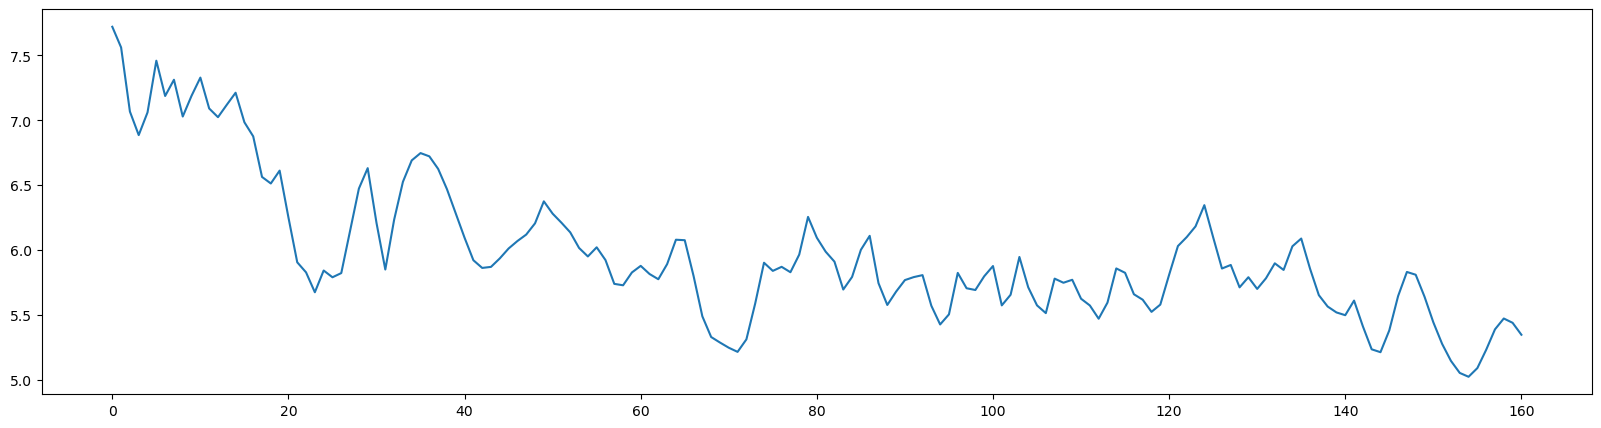

In [ ]:
plt.figure(figsize=(20, 5)) 
plt.plot(idk.nnls_results[2][:,0,:].sum(axis = 0))    
plt.show()

In [ ]:
idk.nnls_results[0].shape, idk.nnls_results[2].shape

KeyError: 0

In [ ]:
# find correlation between nnls results (10 x 10 correlation matrix)
correlation_matrix = np.zeros((nmf_components, nmf_components))
for i in range(nmf_components):
    for j in range(nmf_components):
        correlation_matrix[i,j] = np.corrcoef(idk.nnls_results[0][i].flatten(), idk.nnls_results[2][j].flatten())[0,1]

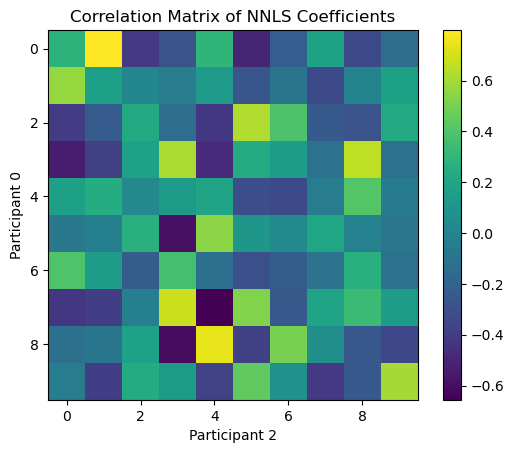

In [ ]:
# plot correlation matrix
plt.imshow(correlation_matrix, cmap='viridis')
plt.colorbar()
plt.title("Correlation Matrix of NNLS Coefficients")
plt.xlabel("Participant 2")
plt.ylabel("Participant 0")
plt.show()

In [ ]:
raise ValueError("Stop here")

ValueError: Stop here